# Analyze Missclassifications

In [214]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

## Load Original Flows

In [215]:
# Configuration
dataset = "darpa2000"
scenario = "s1_inside"

In [216]:
df = pd.read_csv(
    f"../data/interim/{dataset}/{scenario}/flows_labeled/all_flows_labeled.csv"
)

df = df.sort_values("start_time").reset_index(drop=True)
df['t_rel'] = df['start_time'] - df['start_time'].min()

In [217]:
phase_bounds = (
    df[df['phase'] > 0]
    .groupby('phase')['t_rel']
    .agg(['min', 'max'])
)

phase_start = phase_bounds['min'].to_dict()
phase_end   = phase_bounds['max'].to_dict()

In [218]:
phase_bounds

,min,max
phase,,
1,1799.665435,1824.341042
2,2790.877254,3333.974143
3,4294.134775,4402.837414
4,5305.272464,5357.444592
5,7478.960660,8383.254878


## Helper Functions

### Metrics

In [219]:
def is_hard_violation(row, phase_start):
    pred_phase = row['y_pred']
    t = row['t_rel']

    if pred_phase == 0:
        return False

    for prev_p in range(1, pred_phase):
        if prev_p in phase_start:
            if t < phase_start[prev_p]:
                return True

    return False

In [220]:
def is_soft_violation(row, phase_start):
    pred_phase = row['y_pred']
    t = row['t_rel']

    if pred_phase == 0:
        return False

    next_phase = pred_phase + 1

    if next_phase in phase_start:
        if t >= phase_start[next_phase]:
            return True

    return False

In [221]:
def mis_metrics(mis_df, phase_start):
    mis_df['hard_violation'] = mis_df.apply(
        is_hard_violation,
        axis=1,
        phase_start=phase_start
    )

    mis_df['soft_violation'] = mis_df.apply(
        is_soft_violation,
        axis=1,
        phase_start=phase_start
    )

    wrong = mis_df[mis_df['phase'] != mis_df['y_pred']]

    hard = wrong[wrong['hard_violation']]
    soft = wrong[(~wrong['hard_violation']) & (wrong['soft_violation'])]
    plausible = wrong[(~wrong['hard_violation']) & (~wrong['soft_violation'])]

    return wrong, hard, soft, plausible

### Plots

In [222]:
def plot_mis_predictions(df, phase_bounds, plausible, soft, hard, total_wrong, soft_rate, hard_rate):
    
    plt.figure(figsize=(14, 5))

    # --- True phase over time ---
    plt.plot(
        df['t_rel'],
        df['phase'],
        color='black',
        linewidth=1,
        alpha=0.3,
        label="True phase"
    )

    # --- Shaded phase intervals ---
    for phase, bounds in phase_bounds.iterrows():
        plt.axvspan(
            bounds['min'],
            bounds['max'],
            alpha=0.05
        )

    # --- Plausible errors ---
    plt.scatter(
        plausible['t_rel'],
        plausible['y_pred'],
        s=60,
        alpha=0.8,
        label='Wrong but temporally plausible'
    )

    # --- Soft violations ---
    plt.scatter(
        soft['t_rel'],
        soft['y_pred'],
        s=70,
        marker='s',
        alpha=0.9,
        label='Soft violation (phase regression)'
    )

    # --- Hard violations ---
    plt.scatter(
        hard['t_rel'],
        hard['y_pred'],
        s=90,
        marker='X',
        edgecolor='black',
        linewidth=0.6,
        zorder=3,
        label='Hard violation (causal impossibility)'
    )

    # --- Cosmetics ---
    plt.xlabel("Relative time")
    plt.ylabel("Phase")
    plt.title("Temporal Consistency of Phase Predictions")

    plt.yticks(sorted(df['phase'].unique()))
    plt.grid(alpha=0.2)

    plt.text(
        0.02,
        0.95,
        f"Total wrong: {total_wrong}\n"
        f"Hard: {len(hard)} ({hard_rate:.2%})\n"
        f"Soft: {len(soft)} ({soft_rate:.2%})",
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

## Analyze Misclassified Flows

In [223]:
results_path = f"../reports/baselines/baselines_analysis.csv"
df_results = pd.read_csv(results_path) 
df_results.head()

,experiment,accuracy,precision,recall,f1,num_errors
0,ensemble_lstm_original_class_weights_w10,0.999622,0.890752,0.979053,0.929069,19
1,ensemble_lstm_resampled_class_weights_w10,0.999523,0.859986,0.981328,0.912855,24
2,ensemble_lstm_resampled_no_class_weights_w10,0.999583,0.861520,0.981352,0.912269,21
3,multi_class_lstm_resampled_class_weights_w50,0.999563,0.940343,0.898702,0.905887,22
4,multi_class_lstm_resampled_class_weights_w100,0.999582,0.903576,0.909950,0.902462,21


### Inspect Model

In [224]:
# Hyperparameters for best-performing model
model = "multi_class_lstm"
variant = "resampled"
weights = "class_weights"
window_size = 50

In [225]:
processed_dir = f"../data/processed/{dataset}/{scenario}/windowed"
results_dir = f"../experiments/{dataset}/{scenario}/baselines/{model}/results"
metrics_file = f"{results_dir}/{model}_{variant}_{weights}_w{window_size}_metrics.json"

In [226]:
with open(metrics_file) as f:
    metrics = json.load(f)

misclassified_indices = metrics["misclassified_indices"]
real_flow_indices = metrics["real_flow_indices"]
mis_y_pred = metrics["y_pred"]
mis_y_true = metrics["y_true"]

mis_df = df.iloc[real_flow_indices].copy()
mis_df["y_true"] = mis_y_true
mis_df["y_pred"] = mis_y_pred


In [227]:
wrong, hard, soft, plausible = mis_metrics(mis_df, phase_start)

total_wrong = len(wrong)

hard_rate = len(hard) / total_wrong if total_wrong > 0 else 0
soft_rate = len(soft) / total_wrong if total_wrong > 0 else 0

print(f"Total wrong: {total_wrong}")
print(f"Hard violations: {len(hard)} ({hard_rate:.2%})")
print(f"Soft violations: {len(soft)} ({soft_rate:.2%})")

Total wrong: 22
Hard violations: 1 (4.55%)
Soft violations: 5 (22.73%)


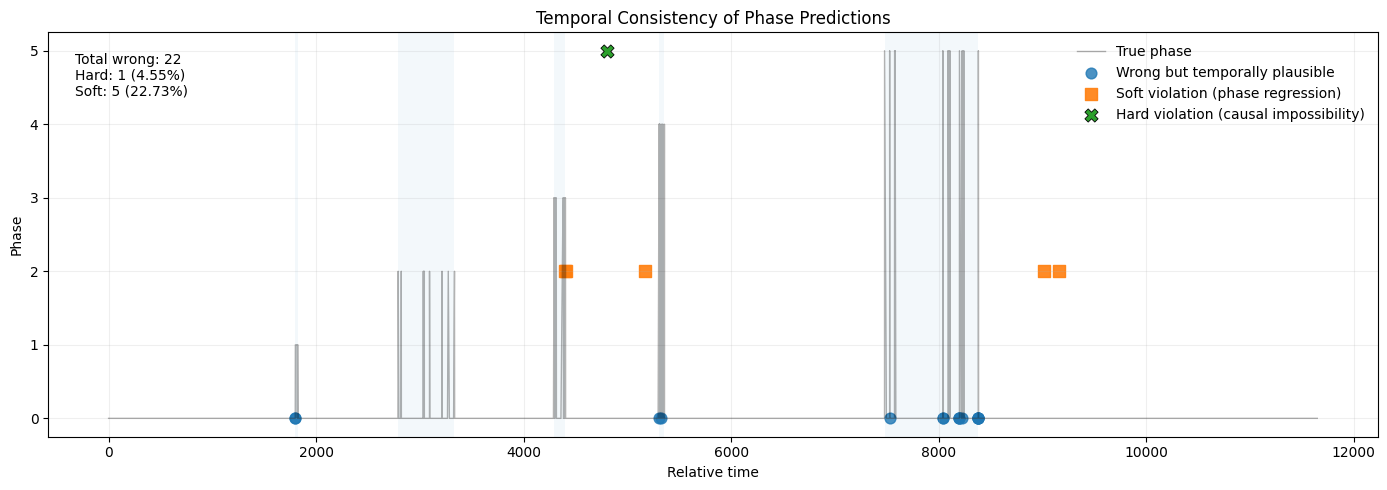

In [228]:
plot_mis_predictions(df, phase_bounds, plausible, soft, hard, total_wrong, soft_rate, hard_rate)

### Manual Analysis

In [229]:
mis_only = mis_df[mis_df["y_true"] != mis_df["y_pred"]]

pd.crosstab(
    mis_only["y_true"],
    mis_only["y_pred"],
)

y_pred,0,2,5
y_true,,,
0,0,4,1
1,2,0,0
3,0,1,0
4,2,0,0
5,12,0,0


### Phase 5 Misclassifications

In [230]:
mis_df[mis_df['phase'] == 5]

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel,y_true,y_pred,hard_violation,soft_violation
39483,f39454,9.524464e+08,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,2,80,-,6,5,7528.056140,5,0,False,False
114604,f114581,9.524469e+08,9.524469e+08,0.052330,172.16.115.5,22702,131.84.1.31,80,tcp,http,...,6,4445,-,6,5,8040.335196,5,0,False,False
114608,f114583,9.524469e+08,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,9,6530,-,6,5,8040.431538,5,0,False,False
115033,f115007,9.524471e+08,9.524471e+08,0.078300,172.16.115.5,24713,131.84.1.31,80,tcp,http,...,9,7092,-,6,5,8200.677959,5,0,False,False
115035,f115008,9.524471e+08,9.524471e+08,0.057650,172.16.115.5,24714,131.84.1.31,80,tcp,http,...,9,8032,-,6,5,8200.779714,5,0,False,False
115037,f115009,9.524471e+08,9.524471e+08,0.072933,172.16.115.5,24715,131.84.1.31,80,tcp,http,...,11,13067,-,6,5,8200.840443,5,0,False,False
115068,f115040,9.524471e+08,9.524471e+08,0.175324,172.16.115.5,25009,131.84.1.31,80,tcp,http,...,37,50871,-,6,5,8227.282637,5,0,False,False
115296,f115255,9.524473e+08,9.524473e+08,0.042587,172.16.115.5,26714,131.84.1.31,80,tcp,http,...,6,4445,-,6,5,8382.889154,5,0,False,False
115300,f115257,9.524473e+08,9.524473e+08,0.053366,172.16.115.5,26716,131.84.1.31,80,tcp,http,...,9,6530,-,6,5,8382.975029,5,0,False,False
115302,f115258,9.524473e+08,9.524473e+08,0.095554,172.16.115.5,26717,131.84.1.31,80,tcp,http,...,18,21837,-,6,5,8383.031037,5,0,False,False


In [231]:
start_index = 114605
indices = range(start_index, start_index+20)
df_filtered = df.iloc[indices]
df_filtered

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel
114605,f114589,9.524469e+08,9.524469e+08,0.000779,172.16.115.5,1079,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.395936
114606,f114582,9.524469e+08,9.524469e+08,0.031471,172.16.115.5,22766,131.84.1.31,80,tcp,http,...,0,ShADdfFa,5,511,4,2432,-,6,5,8040.397506
114607,f114590,9.524469e+08,9.524469e+08,0.000779,172.16.115.5,1080,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.430035
114608,f114583,9.524469e+08,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,0,ShADadfF,7,581,9,6530,-,6,5,8040.431538
114609,f114591,9.524469e+08,9.524469e+08,0.000839,172.16.115.5,1081,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.485207
114610,f114584,9.524469e+08,9.524469e+08,0.095386,172.16.115.5,22893,131.84.1.31,80,tcp,http,...,0,ShADadfF,11,756,18,21837,-,6,5,8040.486750
114611,f114592,9.524469e+08,9.524469e+08,0.000778,172.16.115.5,1082,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.583206
114612,f114585,9.524469e+08,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,0,ShADdfFa,9,659,12,14998,-,6,5,8040.584752
114613,f114593,9.524469e+08,9.524469e+08,0.000805,172.16.115.5,1083,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.664130
114614,f114586,9.524469e+08,9.524469e+08,0.042209,172.16.115.5,23020,131.84.1.31,80,tcp,http,...,0,ShADdfFa,6,542,6,5082,-,6,5,8040.665718


In [232]:
dst_ip = "131.84.1.31"
df_filtered_dst_ip = df[df["dst_ip"] == dst_ip]

phase_counts = df_filtered_dst_ip["phase"].value_counts().sort_index()
phase_counts

phase
0        7
5    73443
Name: count, dtype: int64